In [1]:
import pandas as pd
import glacierml as gl
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import gaussian_kde

pd.set_option('display.max_columns',None)

2024-04-22 08:25:53.519238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-22 08:25:53.519262: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
home_path = '/home/simonhans/glacierml'
[
        data_path, RGI_path, glathida_path, 
        coregistration_testing_path, 
        arch_test_path, LOO_path
] = gl.set_paths(home_path)

In [3]:
df = pd.read_pickle(os.path.join(
    coregistration_testing_path,
    '1','rgi_est_raw.pkl'
))
for i in range(2,5,1):
    dft = pd.read_pickle(
        os.path.join(
            coregistration_testing_path,str(i),'rgi_est_raw.pkl'
        )
    )
    df = pd.merge(df,dft, how = 'inner', on = list(dft)[:-1])
#### Add Farinotti mean thickness estimates ####
ref_pth = 'reference_thicknesses/'
ref = pd.DataFrame()
for file in os.listdir(ref_pth):
    if 'Farinotti' in file:
        file_reader = pd.read_csv('reference_thicknesses/' + file)
        ref = pd.concat([ref, file_reader], ignore_index = True) 
ref = ref.rename(columns = {
     'Farinotti Mean Thickness':'FMT',
})
ref = ref[[
     'FMT',
     'RGIId',
]]

df = pd.merge(df, ref, how = 'inner', on = 'RGIId')
df

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,Zmax,Zmed,Slope,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,region,1,2,3,4,FMT
0,RGI60-01.00001,G213177E63689N,20090703,-9999999,-146.8230,63.6890,1,2,0.360,1936,2725,2385,42.0,346,839,0,0,0,0,9,9,NaN,01,39.513977,29.846027,27.128538,10.710193,19.988910
1,RGI60-01.00002,G213332E63404N,20090703,-9999999,-146.6680,63.4040,1,2,0.558,1713,2144,2005,16.0,162,1197,0,0,0,0,9,9,NaN,01,51.472610,27.857134,52.750446,41.047615,29.413269
2,RGI60-01.00003,G213920E63376N,20090703,-9999999,-146.0800,63.3760,1,2,1.685,1609,2182,1868,18.0,175,2106,0,0,0,0,9,9,NaN,01,48.396648,28.068636,50.151340,40.301865,31.862368
3,RGI60-01.00004,G213880E63381N,20090703,-9999999,-146.1200,63.3810,1,2,3.681,1273,2317,1944,19.0,195,4175,0,0,0,0,9,9,NaN,01,50.370541,31.053043,55.089424,43.676010,45.454704
4,RGI60-01.00005,G212943E63551N,20090703,-9999999,-147.0570,63.5510,1,2,2.573,1494,2317,1914,16.0,181,2981,0,0,0,0,9,9,NaN,01,54.068325,31.428511,58.354675,45.296867,43.040817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216496,RGI60-19.02748,G322268E53986S,20020502,-9999999,-37.7325,-53.9860,19,3,0.042,310,510,-999,29.9,315,255,0,0,0,0,9,9,NaN,19,55.984455,34.229969,48.750462,23.660763,12.593311
216497,RGI60-19.02749,G323864E54831S,20030207,-9999999,-36.1361,-54.8310,19,3,0.567,330,830,-999,23.6,200,1130,0,0,0,0,9,9,NaN,19,73.763718,24.383837,43.826298,31.468248,20.532068
216498,RGI60-19.02750,G322698E54188S,20030207,-9999999,-37.3018,-54.1884,19,3,4.118,10,1110,-999,16.8,308,4329,0,0,0,1,9,9,NaN,19,81.446938,24.352861,79.017387,51.303467,55.923466
216499,RGI60-19.02751,G269573E68866S,19870101,-9999999,-90.4266,-68.8656,19,1,0.011,170,270,-999,0.4,122,106,0,0,0,1,9,9,AQ6C10200013,19,135.516861,32.016491,106.696152,65.568520,10.181019


In [4]:
glac1 = gl.coregister_data(data_path,'1')
glac2 = gl.coregister_data(data_path,'2')
glac3 = gl.coregister_data(data_path,'3')
glac4 = gl.coregister_data(data_path,'4')

df1 = pd.merge(df,glac1, how = 'inner', on = 'RGIId')
df2 = pd.merge(df,glac2, how = 'inner', on = 'RGIId')
df3 = pd.merge(df,glac3, how = 'inner', on = 'RGIId')
df4 = pd.merge(df,glac4, how = 'inner', on = 'RGIId')

df = df.drop(df[df['RGIId'].duplicated(keep = False)].index)

df = df.sample(frac = 1,random_state = 0)
df = df.reset_index().drop('index', axis = 1)

mean residual: -12.3225
residual std 49.906247041327404
Sorting data...
Calculating point density...

mean residual: -13.914285714285715
residual std 32.7774935227307
Sorting data...
Calculating point density...

mean residual: -2.396039603960396
residual std 19.77100547727884
Sorting data...
Calculating point density...

mean residual: -6.2344322344322345
residual std 30.312474996749412
Sorting data...
Calculating point density...



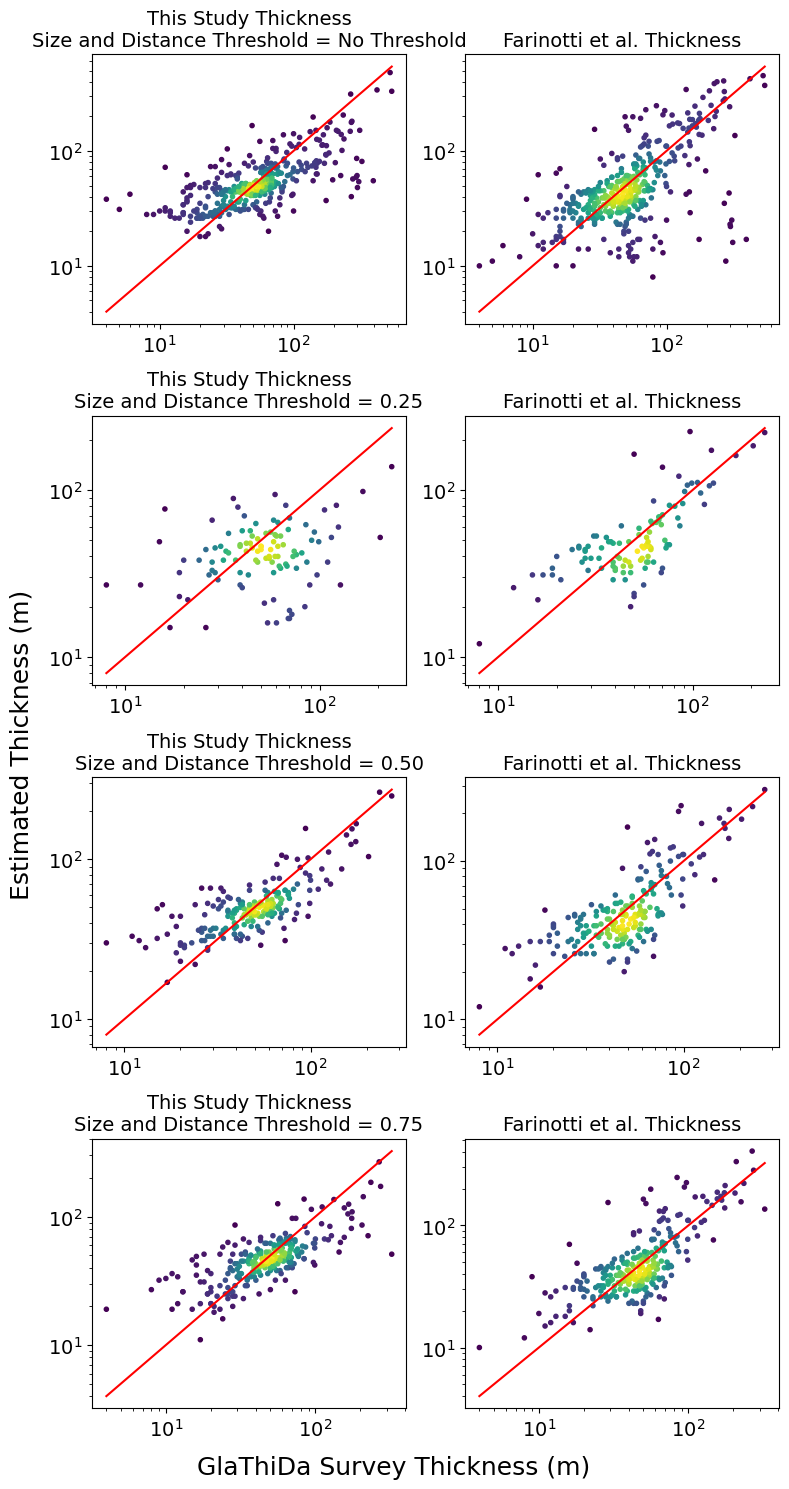

In [5]:
fig, ax = plt.subplots(4,2,figsize = (8,15),
#                        sharex = True, sharey = True
                      )

for n, dataset in enumerate(( df1,df2,
                             df3, df4
                            )):
    n = n+1
    data = dataset
    
    data = data.drop(data[data['RGIId'].duplicated(keep = False)].index)

    if n == 1:
        threshold = 'No Threshold'
    if n == 2:
        threshold = '0.25'
    if n == 3:
        threshold = '0.50'
    if n == 4:
        threshold = '0.75'
#     axs = plt.subplot(4, 1, n+1)
#     print(data)
    data_1 = np.round(data[n],0)
    data_2 = np.round(data['FMT'],0)
    data_3 = np.round(data['Thickness'],0)

    res_mean = np.mean(data_1 - data_3)
    res_std = np.std(data_1-data_3)
    print(f'mean residual: {res_mean}\nresidual std {res_std}')
    # data_1 = ref['Farinotti Mean Thickness'] / 1e3 * ref['Area']
    # data_2 = ref['Edasi Mean Thickness'] / 1e3 * ref['Area']

    print('Sorting data...')
    x_1 = np.sort(data_1)
    y_1 = 1. * np.arange(len(data_1)) / (len(data_1) - 1)

    x_2 = np.sort(data_2)
    y_2 = 1. * np.arange(len(data_2)) / (len(data_2) - 1)

    x_3 = np.sort(data_3)
    y_3 = 1. * np.arange(len(data_3)) / (len(data_3) - 1)

    print('Calculating point density...')
    print('')
    # Calculate the point density
    xy = np.vstack([np.log10(data_1),np.log10(data_3)])

    z_1 = gaussian_kde(xy)(xy)

    yz = np.vstack([np.log10(data_2),np.log10(data_3)])

    z_2 = gaussian_kde(yz)(yz)
    
    ax[n-1,0].scatter(
            data_3,
            data_1,
            c = z_1,
            cmap = 'viridis',
            marker = '.'
        )
    ax[n-1,0].set_xscale('log')
    ax[n-1,0].set_yscale('log')
    ax[n-1,0].plot(
        (data['Thickness'].min(), data['Thickness'].max()),
        (data['Thickness'].min(), data['Thickness'].max()),
        color = 'red',
        linestyle = '-'
    )
    
#     ax[n,0].set_xlabel('GlaThiDa Survey Thickness (m)')
#     ax[n,0].set_ylabel('Estimated Thickness (m)')
    ax[n-1,0].set_title('This Study Thickness\nSize and Distance Threshold = ' + threshold,
                     fontsize = 14)
    
    ax[n-1,1].scatter(
            data_3,
            data_2,
            c = z_2,
            cmap = 'viridis',
            marker = '.'
        )
    ax[n-1,1].plot(
        (data['Thickness'].min(), data['Thickness'].max()),
        (data['Thickness'].min(), data['Thickness'].max()),
        color = 'red',
        linestyle = '-'
    )
    ax[n-1,1].set_xscale('log')
    ax[n-1,1].set_yscale('log')
    ax[n-1,1].set_title('Farinotti et al. Thickness',
                     fontsize = 14)
    ax[n-1,0].tick_params(axis="both", labelsize=14)
    ax[n-1,1].tick_params(axis="both", labelsize=14)
#     ax[n,1].set_xlabel('GlaThiDa Survey Thickness (m)')
#     ax[n,1].set_ylabel('Farinotti Estimated Thickness (m)')
#     ax[n,1].set_title('Farinotti et al. 2019')
    
# plt.suptitle('Comparison of Non-Ice Sheet Glacier Thickness Estimates', y = 0.99)
fig.supylabel('Estimated Thickness (m)', fontsize = 18)
fig.supxlabel('GlaThiDa Survey Thickness (m)', fontsize = 18)

plt.tight_layout()

mean residual: -12.0
residual std 50.0
Sorting data...
Calculating point density...

mean residual: -14.0
residual std 33.0
Sorting data...
Calculating point density...

mean residual: -2.0
residual std 20.0
Sorting data...
Calculating point density...

mean residual: -6.0
residual std 30.0
Sorting data...
Calculating point density...



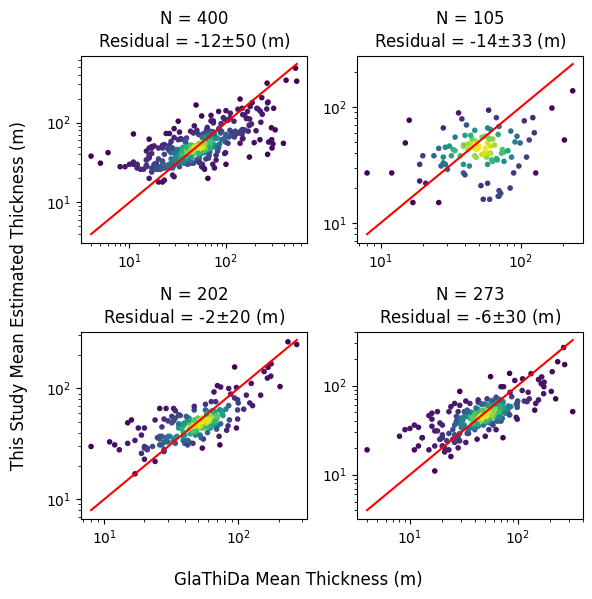

In [6]:
fig, ax = plt.subplots(2,2,figsize = (6,6),
#                        sharex = True, sharey = True
                      )

for n, dataset in enumerate((df1, df2,
                             df3, df4
                            )):
    data = dataset
    data = data.drop(data[data['RGIId'].duplicated(keep = False)].index)

    data_1 = np.round(data[n+1],0)
    data_3 = np.round(data['Thickness'],0)

    res_mean = np.round(np.mean(data_1 - data_3),0)
    res_std = np.round(np.std(data_1-data_3),0)
    print(f'mean residual: {res_mean}\nresidual std {res_std}')
#     data_1 = data['FMT'] / 1e3 * data['Area_x']

    print('Sorting data...')
    x_1 = np.sort(data_1)
    y_1 = 1. * np.arange(len(data_1)) / (len(data_1) - 1)

    x_3 = np.sort(data_3)
    y_3 = 1. * np.arange(len(data_3)) / (len(data_3) - 1)

    print('Calculating point density...')
    print('')
    # Calculate the point density
    xy = np.vstack([np.log10(data_1),np.log10(data_3)])

    z = gaussian_kde(xy)(xy)   
    if n == 0:
        ax[0,0].scatter(
                data_3,
                data_1,
                c = z,
                cmap = 'viridis',
                marker = '.'
            )    
        ax[0,0].set_xscale('log')
        ax[0,0].set_yscale('log')
        ax[0,0].set_title(
            f'N = {len(data)}\nResidual = {res_mean:.0f}$\pm${res_std:.0f} (m)'
                         )
        ax[0,0].plot(
            (data_3.min(), data_3.max()),
            (data_3.min(), data_3.max()),
            color = 'red',
            linestyle = '-'
        )
    if n == 1:
        ax[0,1].scatter(
                data_3,
                data_1,
                c = z,
                cmap = 'viridis',
                marker = '.'
            ) 
        
        ax[0,1].set_xscale('log')
        ax[0,1].set_yscale('log')
        ax[0,1].set_title(
            f'N = {len(data)}\nResidual = {res_mean:.0f}$\pm${res_std:.0f} (m)'
                         )
        ax[0,1].plot(
            (data_3.min(), data_3.max()),
            (data_3.min(), data_3.max()),
            color = 'red',
            linestyle = '-'
        )
    if n == 2:
        ax[1,0].scatter(
                data_3,
                data_1,
                c = z,
                cmap = 'viridis',
                marker = '.'
            )    
        
        ax[1,0].set_xscale('log')
        ax[1,0].set_yscale('log')
        ax[1,0].set_title(
            f'N = {len(data)}\nResidual = {res_mean:.0f}$\pm${res_std:.0f} (m)'
        )
        ax[1,0].plot(
            (data_3.min(), data_3.max()),
            (data_3.min(), data_3.max()),
            color = 'red',
            linestyle = '-'
        )
    if n == 3:
        ax[1,1].scatter(
                data_3,
                data_1,
                c = z,
                cmap = 'viridis',
                marker = '.'
        )    
        ax[1,1].set_xscale('log')
        ax[1,1].set_yscale('log')
        ax[1,1].set_title(
            f'N = {len(data)}\nResidual = {res_mean:.0f}$\pm${res_std:.0f} (m)'
        )
        ax[1,1].plot(
            (data_3.min(), data_3.max()),
            (data_3.min(), data_3.max()),
            color = 'red',
            linestyle = '-'
        )

fig.supylabel('This Study Mean Estimated Thickness (m)')
fig.supxlabel('GlaThiDa Mean Thickness (m)')

plt.tight_layout()